# Домашнее задание.
## Полносвязные нейронные сети. Применение Dropout.

In [0]:
from IPython.display import Image, clear_output
from IPython.core.display import HTML 
Image(url= "http://juice-health.ru/images/technology/32.png")

## Проблема

<b>Переобучение (overfitting) — одна из проблем глубоких нейронных сетей, состоящая в следующем: модель хорошо объясняет только примеры из обучающей выборки, адаптируясь к обучающим примерам, вместо того чтобы учиться классифицировать примеры, не участвовавшие в обучении (теряя способность к обобщению).

In [0]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png")

## Идея

<b>Главная идея Dropout — вместо обучения одной нейронной сети обучить ансамбль нескольких нейронных сетей, а затем усреднить полученные результаты.

## Реализация

<b>Сети для обучения получаются с помощью исключения из сети (dropping out) нейронов с вероятностью $p$(в семинаре $keep\_rate$), таким образом, вероятность того, что нейрон останется в сети, составляет $q = 1 - p$. “Исключение” нейрона означает, что при любых входных данных или параметрах он возвращает 0.

 Слева — нейронная сеть до того, как к ней применили Dropout, справа — та же сеть после Dropout.

In [0]:
Image(url= "https://hsto.org/web/dd8/171/16f/dd817116fc2348e78272577153e31d2d.jpeg")

## Результат

<b>Исключенные нейроны не вносят свой вклад в процесс обучения ни на одном из этапов алгоритма обратного распространения ошибки (backpropagation), поэтому исключение хотя бы одного из нейронов равносильно обучению новой нейронной сети.
В двух словах, Dropout хорошо работает на практике, потому что предотвращает взаимоадаптацию нейронов на этапе обучения.

-----------------------------------------------------------------------------

<b>Посмотрим как хорошо на практике работает Dropout. Будем решать задачу регресиию. Сгенерируем две выборки $test\_y$, $y$ из одного распределения и будем обучаться на $y$, а смотреть ошибку на $test\_y$. Будем использовать два способа обучения: c использованием Dropout и без него. 

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
%config InlineBackend.figure_format = 'svg' 
torch.manual_seed(2)   
np.random.seed(2)

Мы показываем вам, как были сгенерированы $y$ и $test\_y$, но, чтобы наблюдать правильность выполнения задания, мы зафиксировали какие-то рандомные выборки из этого распределения.

In [0]:
# Кол-во точек 
N_SAMPLES = 20

# Строим выборку для обучения 
x = torch.linspace(-1, 1, N_SAMPLES).view(N_SAMPLES, -1)
#y = x + 0.3 * torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
y = torch.tensor([[-1.3122],[-0.6198],[-1.1807],[-1.0171],[-0.5700],[-0.4886],[-0.0489],[ 0.0027],[-0.4012],[ 0.1495]
                  ,[-0.2844],[ 0.1303],[ 0.3053],[ 0.7042],[ 0.5683],[ 1.1048],[ 0.4623],[ 0.4167],[ 0.8422],[ 1.2097]])

# Строим тестовую выборку
test_x = torch.linspace(-1, 1, N_SAMPLES).view(N_SAMPLES, -1)
#test_y = test_x + 0.3 * torch.normal(torch.zeros(N_SAMPLES, 1), torch.ones(N_SAMPLES, 1))
test_y = torch.tensor([[-1.3883],[-0.9020],[-0.8601],[-0.8968],[-0.2950],[-1.0038],[-0.5611],[ 0.4919],[-0.4285],[-0.0572],
                       [ 0.4683],[ 0.9315],[ 0.1591],[ 0.3946],[ 0.1438],[ 0.7278],[ 1.1072],[ 0.6730],[ 1.0141],[ 0.6687]])

Отобразим наши данные:

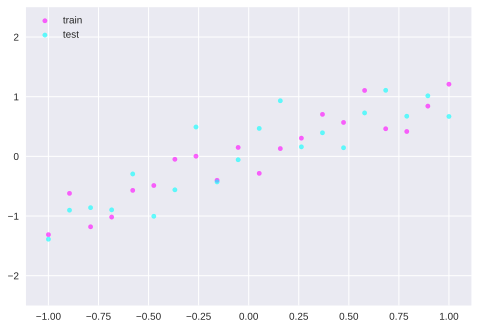

In [3]:
plt.scatter(x.numpy(), y.numpy(), c='magenta', s=20, alpha=0.6, label='train')
plt.scatter(test_x.numpy(), test_y.numpy(), c='cyan', s=20, alpha=0.6, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

 <b>Важно! На вход нам подается один нейрон, так как точка $x$ имеет один признак(координату), всего объектов 20. Для каждого объкта независимо от других прогнозируется его $y$, но линейное преобразование на определенном слое для каждого объекта одинакова, а веса этого слоя определяются из минимизации суммарной ошибки на $y$</b>
 
 Создадим нейронную сеть с 3 линейными слоями и в качестве нелинейности используем ReLU:

In [4]:
N_HIDDEN = 300
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)
print(net_overfitting)  # архитектура сети

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
)


<b>Порядок Dropout и ReLU не влияет на результат, так как неважно, выбрасывать нейрон после активации или до.

Добавим Dropout после первого и второго слоя с keep_rate=0.5, то есть удаляем нейрон с вероятностью 0.5:

In [5]:
net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5), 
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5), 
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)
print(net_dropped) # архитектура сети

Sequential(
  (0): Linear(in_features=1, out_features=300, bias=True)
  (1): Dropout(p=0.5)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=300, bias=True)
  (4): Dropout(p=0.5)
  (5): ReLU()
  (6): Linear(in_features=300, out_features=1, bias=True)
)


Зададим градиентный спуск каждой нейронной сети:

In [0]:
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)

Зададим квадратичную функцию потерь:

In [0]:
loss_func = torch.nn.MSELoss()

overfitting loss train dropout loss train
0.0165			0.0833
0.0139			0.1210
0.0137			0.0963
0.0149			0.0916
0.0145			0.1086
0.0152			0.1000
0.1027			0.0853
0.0190			0.1211
0.0149			0.1021
0.0136			0.1141
0.0129			0.1074
0.0132			0.0992
0.0127			0.1009
0.0123			0.1256
0.0121			0.1005
0.0119			0.0801
0.0117			0.1348
0.0115			0.0518
0.0113			0.2067
0.0111			0.1101
0.0108			0.0952
0.0104			0.1391
0.0101			0.0959
0.0168			0.1578
0.0102			0.0608

overfitting loss    dropout loss
0.1803			0.1434
0.1832			0.1643
0.1869			0.1559
0.1862			0.1364
0.1870			0.1374
0.1853			0.1447
0.3764			0.1496
0.1669			0.1415
0.1742			0.1401
0.1797			0.1391
0.1820			0.1740
0.1885			0.1790
0.1849			0.1464
0.1828			0.1678
0.1837			0.1501
0.1836			0.1807
0.1823			0.1328
0.1818			0.1448
0.1803			0.1607
0.1805			0.1416
0.1801			0.1465
0.1791			0.1611
0.1782			0.1768
0.1751			0.1857
0.1773			0.1585


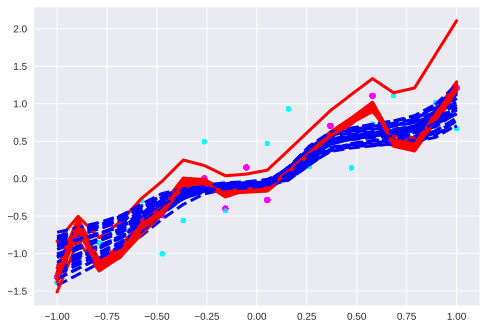

In [10]:
# Ошибки на y и test_y
error = []
error_test = []
for t in range(500):
    # Пропустим x по нейронной сети
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)

    # Cделаем шаг градиентного спуска
    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()
    
    if t % 20 == 0:
        # перейдем к режиму eval, чтобы учесть поправку dropout
        net_overfitting.eval()
        net_dropped.eval()

#         # plotting
#         clear_output(wait=True)
#         sleep(0.05)
        
         # Пропустим test_x по нейронной сети
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        
        #Отобразим наши данные и предсказания различных нейронных сетей на тестовых данных:
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=30, alpha=0.6, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=20, alpha=0.6, label='test')
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        
        # Ошибка на y и на на test_y
        error.append((loss_func(pred_ofit, y).data.numpy(), loss_func(pred_drop, y).data.numpy()))
        error_test.append((loss_func(test_pred_ofit, test_y).data.numpy(), loss_func(test_pred_drop, test_y).data.numpy()))
        
#         plt.text(-0.5, -1.8, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
#         plt.text(-0.5, -2.3, 'dropout loss=%.4f' % loss_func(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
#         plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5))
#         plt.show()
        
        # вернемся к режиму train
        net_overfitting.train()
        net_dropped.train()

# Выведим ошибки двух сетей попарно на y:
print('overfitting loss train', 'dropout loss train')
for i in range(len(error)):
    print('%.4f\t\t\t%.4f' % (error[i][0], error[i][1]))

print()
# Выведим ошибки двух сетей попарно на test_y:
print('overfitting loss', '   dropout loss')
for i in range(len(error)):
    print('%.4f\t\t\t%.4f' % (error_test[i][0], error_test[i][1]))

# Вопросы:
1. Какая суммарная квадратичная ошибка между $y$ и $test\_y$? (c помощью loss_func)
<br>Ответ: 0.1770
2. Сколько параметров у линейного скрытого слоя (не забудьте про свободный член b)?
<br> Ответ: 90300
3. Какая у вас получилась ошибка $overfitting\:loss\:train$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.02
4. Какая у вас получилась ошибка $dropout\:loss\:train$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.08
5. Какая у вас получилась ошибка $overfitting\:loss$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.19
6. Какая у вас получилась ошибка $dropout\:loss$ в итоге (округлите до 2 знаков после запятой)?
<br> Ответ: 0.15

<br> Сравните 3, 4 и подумайте, почему так получилось?
<br> Сравните 4, 5 и подумайте, почему так получилось?
<br> Так же сравните 4, 5 с предыдущими двумя ошибками.